지난 시간, Day4_1_word2vec_and_doc2vec_moviereview.ipynb에서 영화 리뷰를 이용하여 172개의 영화의 임베딩 백터를 구하였습니다. 이 벡터를 이용하여 리뷰가 비슷한 영화들을 군집화 해보겠습니다. 

{영화 id: 영화 이름} dict와 pickling을 한 doc2vec model을 loading 하겠습니다. 이전 시간의 모델을 이용하기 때문에 이번 day5_1의 gensim version 역시 0.13.x입니다. version 1.0.1은 이후에 올려드리겠습니다. (이 튜토리얼을 만들고나서 또 gensim version이 2.x로 올랐습니다. 2.x로 만들어드리겠습니다)

id2movie의 형태는 아래와 같습니다. 

    {'98896': '교통신호',
     '75104': 'To',
     '22938': '제3공작',
     '28840': '허리케인 카터',
     '22757': '임 그리워',
     ...
    }

In [1]:
import pickle

with open('../../../data/sample_naver_movie/movie_review_doc2vec_model.pkl', 'rb') as f:
    doc2vec_model = pickle.load(f)
    
with open('../../../data/sample_naver_movie/navermovie_info_idx2moviename.pkl', 'rb') as f:
    id2movie = pickle.load(f)

Doc2Vec에서 document (영화)의 임베딩 차원은 300이며, 영화의 개수는 172개임을 확인할 수 있습니다. 

In [2]:
doc2vec_model.docvecs.doctag_syn0.shape

(172, 300)

172개의 각 row에 해당하는 영화가 무엇인지 제목을 미리 list로 만들어 두겠습니다. Gensim version 0.13.x에서는 각 row id에 해당하는 label이 dict 형태로, Doc2Vec.docvecs.doctags에 저장되어 있습니다. 

    > doc2vec_model.docvecs.doctags
    
    {'MOVIE_100647': Doctag(offset=153, word_count=300107, doc_count=20577),
     'MOVIE_100691': Doctag(offset=155, word_count=310711, doc_count=19777),
     'MOVIE_100931': Doctag(offset=28, word_count=548150, doc_count=36068),
     'MOVIE_102272': Doctag(offset=84, word_count=580131, doc_count=33614),
     'MOVIE_102817': Doctag(offset=13, word_count=386768, doc_count=26021),
     'MOVIE_102824': Doctag(offset=103, word_count=227555, doc_count=13078),
     'MOVIE_102875': Doctag(offset=54, word_count=659849, doc_count=40894),
     ...
     }
     
위 예시에서 영화 id 100647의 row id는 offset=153, 153번 입니다. docvecs.doctags으로부터 아래의 코드를 실행하면 row 별 영화 이름을 얻을 수 있습니다. 
 
작업의 각 부분들의 내용을 확인하기 위해 step 별로 list의 3개의 값을 출력하였습니다. 
 

In [15]:
row2movie = sorted(doc2vec_model.docvecs.doctags.items(), key=lambda x:x[1].offset)
print('dict.items()를 하면 (key,value)의 list가 만들어집니다')
print(row2movie[:3], '\n')

row2movie = [row[0].split('_')[1] for row in row2movie]
print('row[0]에 의해 key들의 list가 만들어지고, str인 key를 _로 split한 뒤 [1]을 가져왔기 때문에 영화 id가 str 형식으로 만들어집니다')
print(row2movie[:3], '\n')

row2movie = [id2movie.get(row, None) for row in row2movie]
print('id2movie를 이용하여 str 형식의 영화 id를 영화 이름으로 바꿉니다')
print(row2movie[:3], '\n')

dict.items()를 하면 (key,value)의 list가 만들어집니다
[('MOVIE_72523', Doctag(offset=0, word_count=94513, doc_count=10187)), ('MOVIE_59845', Doctag(offset=1, word_count=144494, doc_count=13095)), ('MOVIE_109753', Doctag(offset=2, word_count=202367, doc_count=10361))] 

row[0]에 의해 key들의 list가 만들어지고, str인 key를 _로 split한 뒤 [1]을 가져왔기 때문에 영화 id가 str 형식으로 만들어집니다
['72523', '59845', '109753'] 

id2movie를 이용하여 str 형식의 영화 id를 영화 이름으로 바꿉니다
['고사 두 번째 이야기: 교생실습', '박쥐', '해무'] 



    KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')
    
k-means의 parameter는 위와 같습니다. 

- k의 값은 n_clusters입니다. 
- n_init은 반복 횟수이므로 1로 바꾸겠습니다. 
- 일반적으로 k-means는 엄청 큰 데이터라 하여도 10번, 혹은 수십번이면 거의 수렴합니다. 
- max_iter 역시 작은 숫자로 바꿔서 실행하시는게 좋습니다. 
- n_jobs는 multi-processing을 하기 위한 processor의 개수입니다. 수업 서버에서는 그대로 1을, 개인 작업 시에는 이용하고픈 processor의 개수를 입력합니다. 
- verbose = 1로 설정하면, 매 iteration마다 학습 상태가 출력됩니다. 속도를 측정할 때 용이합니다. 

또한, spherical k-means를 하기 위해서는 metrics='cosine'으로 바꿔야 하지만, k-means는 Euclidean을 기준으로 만들어졌습니다. 만약 spherical k-means를 하고 싶다면, (172, 300)의 행렬을 row normalize하여 unit vector로 만들기 바랍니다. 

우리는 172개의 영화를 10개의 그룹으로 만들어 보겠습니다. 172개를 10개로 나누는 것은 그리 어려운 작업은 아닌가봅니다. 그래서 max_iter=10이었지만, 실제 iteration은 그 전에 끝남을 볼 수 있습니다. 

In [54]:
from sklearn.preprocessing import normalize
movie_vectors = normalize(doc2vec_model.docvecs.doctag_syn0, axis=1, norm='l2')

In [55]:
%%time

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, max_iter=10, n_init=1, verbose=1)
print('kmeans.fit_predict()')
clusters = kmeans.fit_predict(movie_vectors)

print('\n\nkmeans.fit_transform()')
distance = kmeans.fit_transform(movie_vectors)

kmeans.fit_predict()
Initialization complete
Iteration  0, inertia 121.403
Iteration  1, inertia 73.420
Iteration  2, inertia 72.491
Iteration  3, inertia 72.304
Converged at iteration 3


kmeans.fit_transform()
Initialization complete
Iteration  0, inertia 118.204
Iteration  1, inertia 74.116
Iteration  2, inertia 72.721
Iteration  3, inertia 71.958
Iteration  4, inertia 71.747
Iteration  5, inertia 71.722
Converged at iteration 5
CPU times: user 104 ms, sys: 0 ns, total: 104 ms
Wall time: 18.9 ms


kmeans는 .fit_predict()와 .fit_transform() 두 가지 함수가 있습니다. 

    kmeans.fit_predict(doc2vec_model.docvecs.doctag_syn0)
    
fit_predict는 각 row의 label을 하나로 출력해줍니다. 

    kmeans.fit_transform(doc2vec_model.docvecs.doctag_syn0)
    
fit_transform은 각 row 별로 k 개의 centroid와의 거리를 출력해줍니다. 

In [56]:
clusters

array([2, 2, 5, 7, 5, 0, 2, 0, 6, 2, 7, 5, 0, 5, 1, 9, 0, 1, 0, 1, 4, 4, 3,
       0, 9, 5, 0, 5, 4, 2, 5, 0, 4, 8, 4, 5, 7, 9, 2, 3, 5, 0, 2, 8, 1, 0,
       0, 5, 7, 9, 7, 3, 7, 5, 8, 1, 0, 4, 1, 2, 7, 0, 0, 0, 2, 7, 1, 3, 0,
       3, 6, 9, 9, 9, 0, 7, 3, 5, 7, 5, 4, 5, 5, 7, 8, 4, 2, 5, 4, 2, 7, 0,
       8, 4, 5, 5, 6, 4, 1, 4, 0, 9, 1, 0, 4, 7, 4, 5, 4, 6, 0, 8, 3, 2, 0,
       1, 5, 2, 4, 2, 4, 0, 0, 7, 5, 0, 4, 1, 8, 0, 7, 4, 4, 4, 1, 5, 0, 4,
       6, 9, 9, 6, 2, 0, 9, 4, 2, 4, 6, 3, 5, 1, 4, 3, 0, 1, 7, 4, 0, 0, 7,
       0, 1, 2, 5, 1, 1, 9, 7, 5, 1, 0], dtype=int32)

In [58]:
distance.shape

(172, 10)

In [63]:
distance

array([[ 0.99361981,  0.80199192,  0.91104775, ...,  0.8989692 ,
         0.66384844,  0.87982548],
       [ 0.98436291,  0.88503431,  0.94310784, ...,  0.87876421,
         0.68302895,  0.84643174],
       [ 1.15181218,  0.9725205 ,  0.96019144, ...,  1.02288445,
         0.94402923,  0.75132225],
       ..., 
       [ 1.21575709,  0.9570088 ,  0.91185169, ...,  0.99429161,
         0.99784256,  0.81351695],
       [ 1.17892303,  0.98886234,  0.84361714, ...,  1.04737539,
         0.95937746,  0.91026713],
       [ 0.8125239 ,  0.62870587,  0.82235758, ...,  0.53987461,
         0.61864565,  0.86711799]])

같은 cluster label을 지니는 영화별로 그룹을 묶어서 이름을 확인해봅니다. 그 뒤, 각 label 별로 몇 개의 영화가 묶여 있는지 개수를 출력합니다. 

In [59]:
from collections import defaultdict

cluster_to_row = defaultdict(lambda: [])
for row_id, label in enumerate(clusters):
    cluster_to_row[label].append(row_id)
    
cluster_to_row = dict(cluster_to_row)
for label, rows in cluster_to_row.items():
    print('cluster # %d has %d moveis' % (label, len(rows)))

cluster # 0 has 33 moveis
cluster # 1 has 18 moveis
cluster # 2 has 17 moveis
cluster # 3 has 9 moveis
cluster # 4 has 26 moveis
cluster # 5 has 25 moveis
cluster # 6 has 7 moveis
cluster # 7 has 18 moveis
cluster # 8 has 7 moveis
cluster # 9 has 12 moveis


각 cluster 별로 10개씩 영화의 이름을 출력하여, 군집화 결과가 어떤 느낌인지 확인해봅시다. 앞서 만들어둔 row2movie를 이용합니다. 

In [60]:
for label, rows in cluster_to_row.items():
    print('\ncluster # %d' % label)
    for row in rows[:10]:
        print('  > %s' % row2movie[row])


cluster # 0
  > 국가대표
  > 베를린
  > 다크 나이트 라이즈
  > 내가 살인범이다
  > 다크 나이트
  > 영웅: 샐러멘더의 비밀
  > 신세계
  > 인셉션
  > 악마를 보았다
  > 용의자

cluster # 1
  > 배트맨 대 슈퍼맨: 저스티스의 시작
  > 메이즈 러너: 스코치 트라이얼
  > 캡틴 아메리카: 시빌 워
  > 인디펜던스 데이: 리써전스
  > 쥬라기 월드
  > 엑스맨: 데이즈 오브 퓨처 패스트
  > 워크래프트: 전쟁의 서막
  > 혹성탈출: 반격의 서막
  > 어벤져스: 에이지 오브 울트론
  > 터미네이터 제니시스

cluster # 2
  > 고사 두 번째 이야기: 교생실습
  > 박쥐
  > 도둑들
  > 미스터 고
  > 완득이
  > 의형제
  > 좋은 놈, 나쁜 놈, 이상한 놈
  > 박수건달
  > 감시자들
  > 초능력자

cluster # 3
  > 터널
  > 판도라
  > 카트
  > 인사이드 아웃
  > 형
  > 도가니
  > 부산행
  > 소원
  > 히말라야

cluster # 4
  > 과속스캔들
  > 미녀는 괴로워
  > 겨울왕국
  > 타이타닉
  > 지금, 만나러 갑니다
  > 해바라기
  > 왕의 남자
  > 레미제라블
  > 어거스트 러쉬
  > 하울의 움직이는 성

cluster # 5
  > 해무
  > 인터스텔라
  > 럭키
  > 해적: 바다로 간 산적
  > 대호
  > 곡성(哭聲)
  > 빅 히어로
  > 암살
  > 검은 사제들
  > 제이슨 본

cluster # 6
  > 해리 포터와 죽음의 성물 - 2부
  > 트와일라잇
  > 신비한 동물사전
  > 해리 포터와 혼혈 왕자
  > 뉴 문
  > 다세포 소녀
  > 쌍화점

cluster # 7
  > 해운대
  > 7광구
  > 포화 속으로
  > 캐리비안의 해적 - 세상의 끝에서
  > 트랜스포머 3
  > 배틀쉽
  > 감기
  > 스카이라인
  > 2012
  > 맨 오브 스틸

cluster 

kmeans의 KMeans.cluster_centers_ 는 각 centroid의 좌표입니다. 

Doc2Vec 임베딩 벡터의 크기가 300이고, 클러스터의 개수가 10이기 때문에 centers 행렬의 크기는 (10, 300)입니다. 

In [61]:
kmeans.cluster_centers_.shape

(10, 300)

지난 시간에 연습했던 t-SNE를 이용하여 10개의 영화 군집을 시각화 할 수도 있습니다. label로 각 군집의 id와 영화 2개의 이름을 함께 annotation 합니다. 

영화의 개수가 172개 뿐이고, 300차원이기 때문에 10개의 군집으로 묶었을 때, 군집의 centroids의 벡터값이 서로 비슷할 수 있습니다. 이는 시각화의 측면에서는 좋지 않은 영향을 줄 수 있습니다. 시각화는 비슷한 것의 거리는 작게, 비슷하지 않은 것의 거리는 크게 표현되어야 하기 때문입니다. 하지만 k-means의 centroid는 고차원 벡터들의 평균이기 때문입니다. order 이상의 의미가 없을 수 있습니다. 

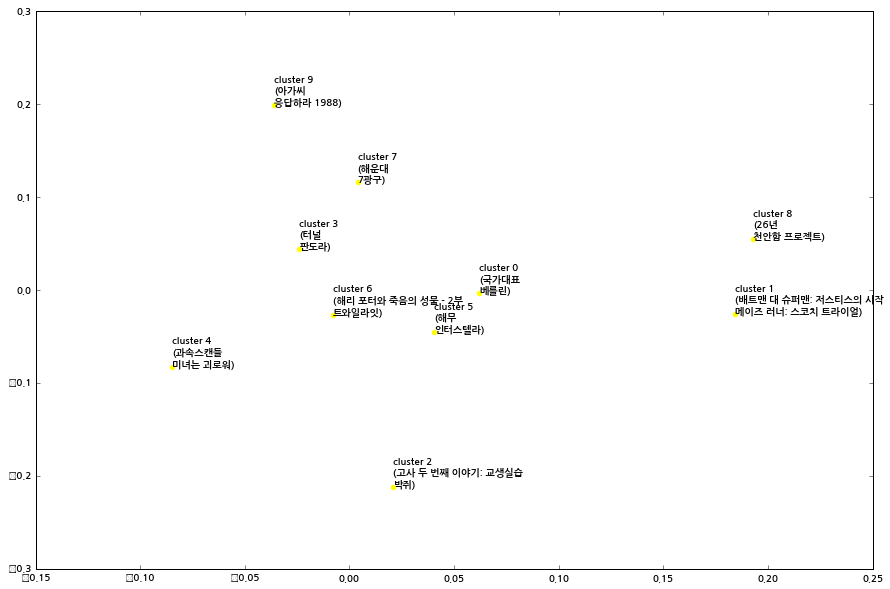

In [62]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
y_tsne = tsne.fit_transform(kmeans.cluster_centers_)
y_tsne = y_tsne*1000


plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')
for i in range(y_tsne.shape[0]):
    one_sample = row2movie[cluster_to_row[i][0]]
    two_sample = row2movie[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (y_tsne[i, 0], y_tsne[i, 1])
                )
plt.show()